## Introduction

The purpose of this notebook is to serve as a simple run of OLS, Ridge, FLR, and RF on the Tecator data set where each functional input $X(t)$ has its columns/wavelengths permuted independently. ChatGPT says that everything except the random forest should break.

We offload most of the computation to `scripts/07_permuted.py` and only pull in plots and results in this notebook.

## Imports

In [7]:
from IPython.display import Image
import os
from pathlib import Path
import pickle
import statistics

import matplotlib.pyplot as plt

from tecatorfda.data import generate_and_load_tecator_data_iid_noise, load_tecator_fat

## Permute the wavelengths across the data set

### Generate the data

In [2]:
project_root = Path.cwd().resolve().parent
original_data_directory = project_root / "data" / "original"

new_directory_string = "07_permuted_uniform"

new_data_directory = project_root / "data" / new_directory_string

new_data = generate_and_load_tecator_data_iid_noise(
    original_data_location=original_data_directory,
    new_data_location=new_data_directory,
    random_seed=0,
    alpha=0.,
    row_idx=None,
    col_idx=None,
    perm_cols=True,
    perm_cols_per_sample=False,
)

### Run the scripts

In [3]:
# Define the data directory to save to.
artifacts_location_directory = project_root / "artifacts" / new_directory_string
output_directory_1 = artifacts_location_directory / "01_ols"
output_directory_2 = artifacts_location_directory / "02_ridge"
output_directory_3 = artifacts_location_directory / "03_flr"
output_directory_6 = artifacts_location_directory / "06_rf"

# Define the data directories to read from.
data_location_directory = new_data_directory

%run ../scripts/01_ols.py --out-dir "{output_directory_1}" --data-location-directory "{new_data_directory}"
%run ../scripts/02_ridge.py --out-dir "{output_directory_2}" --data-location-directory "{data_location_directory}" --artifacts-location-directory "{artifacts_location_directory}"
%run ../scripts/03_flr.py --out-dir "{output_directory_3}" --data-location-directory "{data_location_directory}" --artifacts-location-directory "{artifacts_location_directory}"
%run ../scripts/06_rf.py --out-dir "{output_directory_6}" --data-location-directory "{data_location_directory}" --artifacts-location-directory "{artifacts_location_directory}"

162/1620 runs (10%) | elapsed 5.9s
324/1620 runs (20%) | elapsed 10.8s
486/1620 runs (30%) | elapsed 16.4s
648/1620 runs (40%) | elapsed 23.5s
810/1620 runs (50%) | elapsed 30.7s
972/1620 runs (60%) | elapsed 40.2s
1134/1620 runs (70%) | elapsed 47.8s
1296/1620 runs (80%) | elapsed 56.6s
1458/1620 runs (90%) | elapsed 68.5s
1620/1620 runs (100%) | elapsed 81.7s
Done with analysis plot generation! Proceding to repeated CV.


### Visualize the first 5 wavelength spectra with the mean functional

In [6]:
tecator_df, fat_df, wavelength_grid, wavelength_unit = load_tecator_fat(location=data_location_directory)

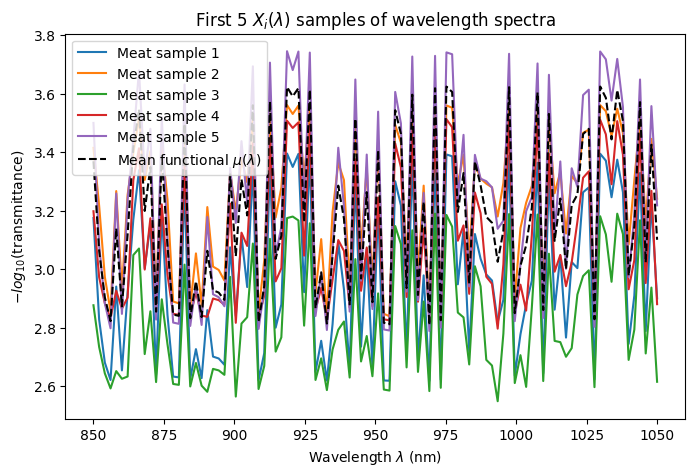

In [8]:
plt.figure(figsize=(8,5))

for i in range(5):
    plt.plot(wavelength_grid, tecator_df.iloc[i], label=f"Meat sample {i+1}")

plt.plot(wavelength_grid, tecator_df.mean(axis=0), linestyle="--", c="black", label=r"Mean functional $\mu(\lambda)$")

plt.title(r"First 5 $X_{i}(\lambda)$ samples of wavelength spectra")
plt.xlabel(rf"Wavelength $\lambda$ ({wavelength_unit})")
plt.ylabel(r"$-log_{10}(\text{transmittance})$")
plt.legend()
plt.show()

### Evaluate repeated CV $R^{2}$

We now repeat a similar experiment as in the end of the notebook `01_ols.ipynb`. We run 10-fold CV ridge regression 10 times to get 100 different generalization $R^{2}$ estimates. This means for each of the 100 estimates, we have CV train and test sets. We take each train set and perform another 10-fold CV to choose the best random forest hyperparameters, then evaluate the resulting random forest on the test set. We report the median, mean, standard deviation, and boxplot of the 100 resulting $R^{2}$ values.

OLS CV R^2 median: 0.9579
OLS CV R^2 mean: 0.9308
OLS CV R^2 standard deviation: 0.0773

Ridge CV R^2 median: 0.9666
Ridge CV R^2 mean: 0.9547
Ridge CV R^2 standard deviation: 0.0431

FLR CV R^2 median: 0.964
FLR CV R^2 mean: 0.9604
FLR CV R^2 standard deviation: 0.0167

RF CV R^2 median: 0.673
RF CV R^2 mean: 0.6345
RF CV R^2 standard deviation: 0.2078



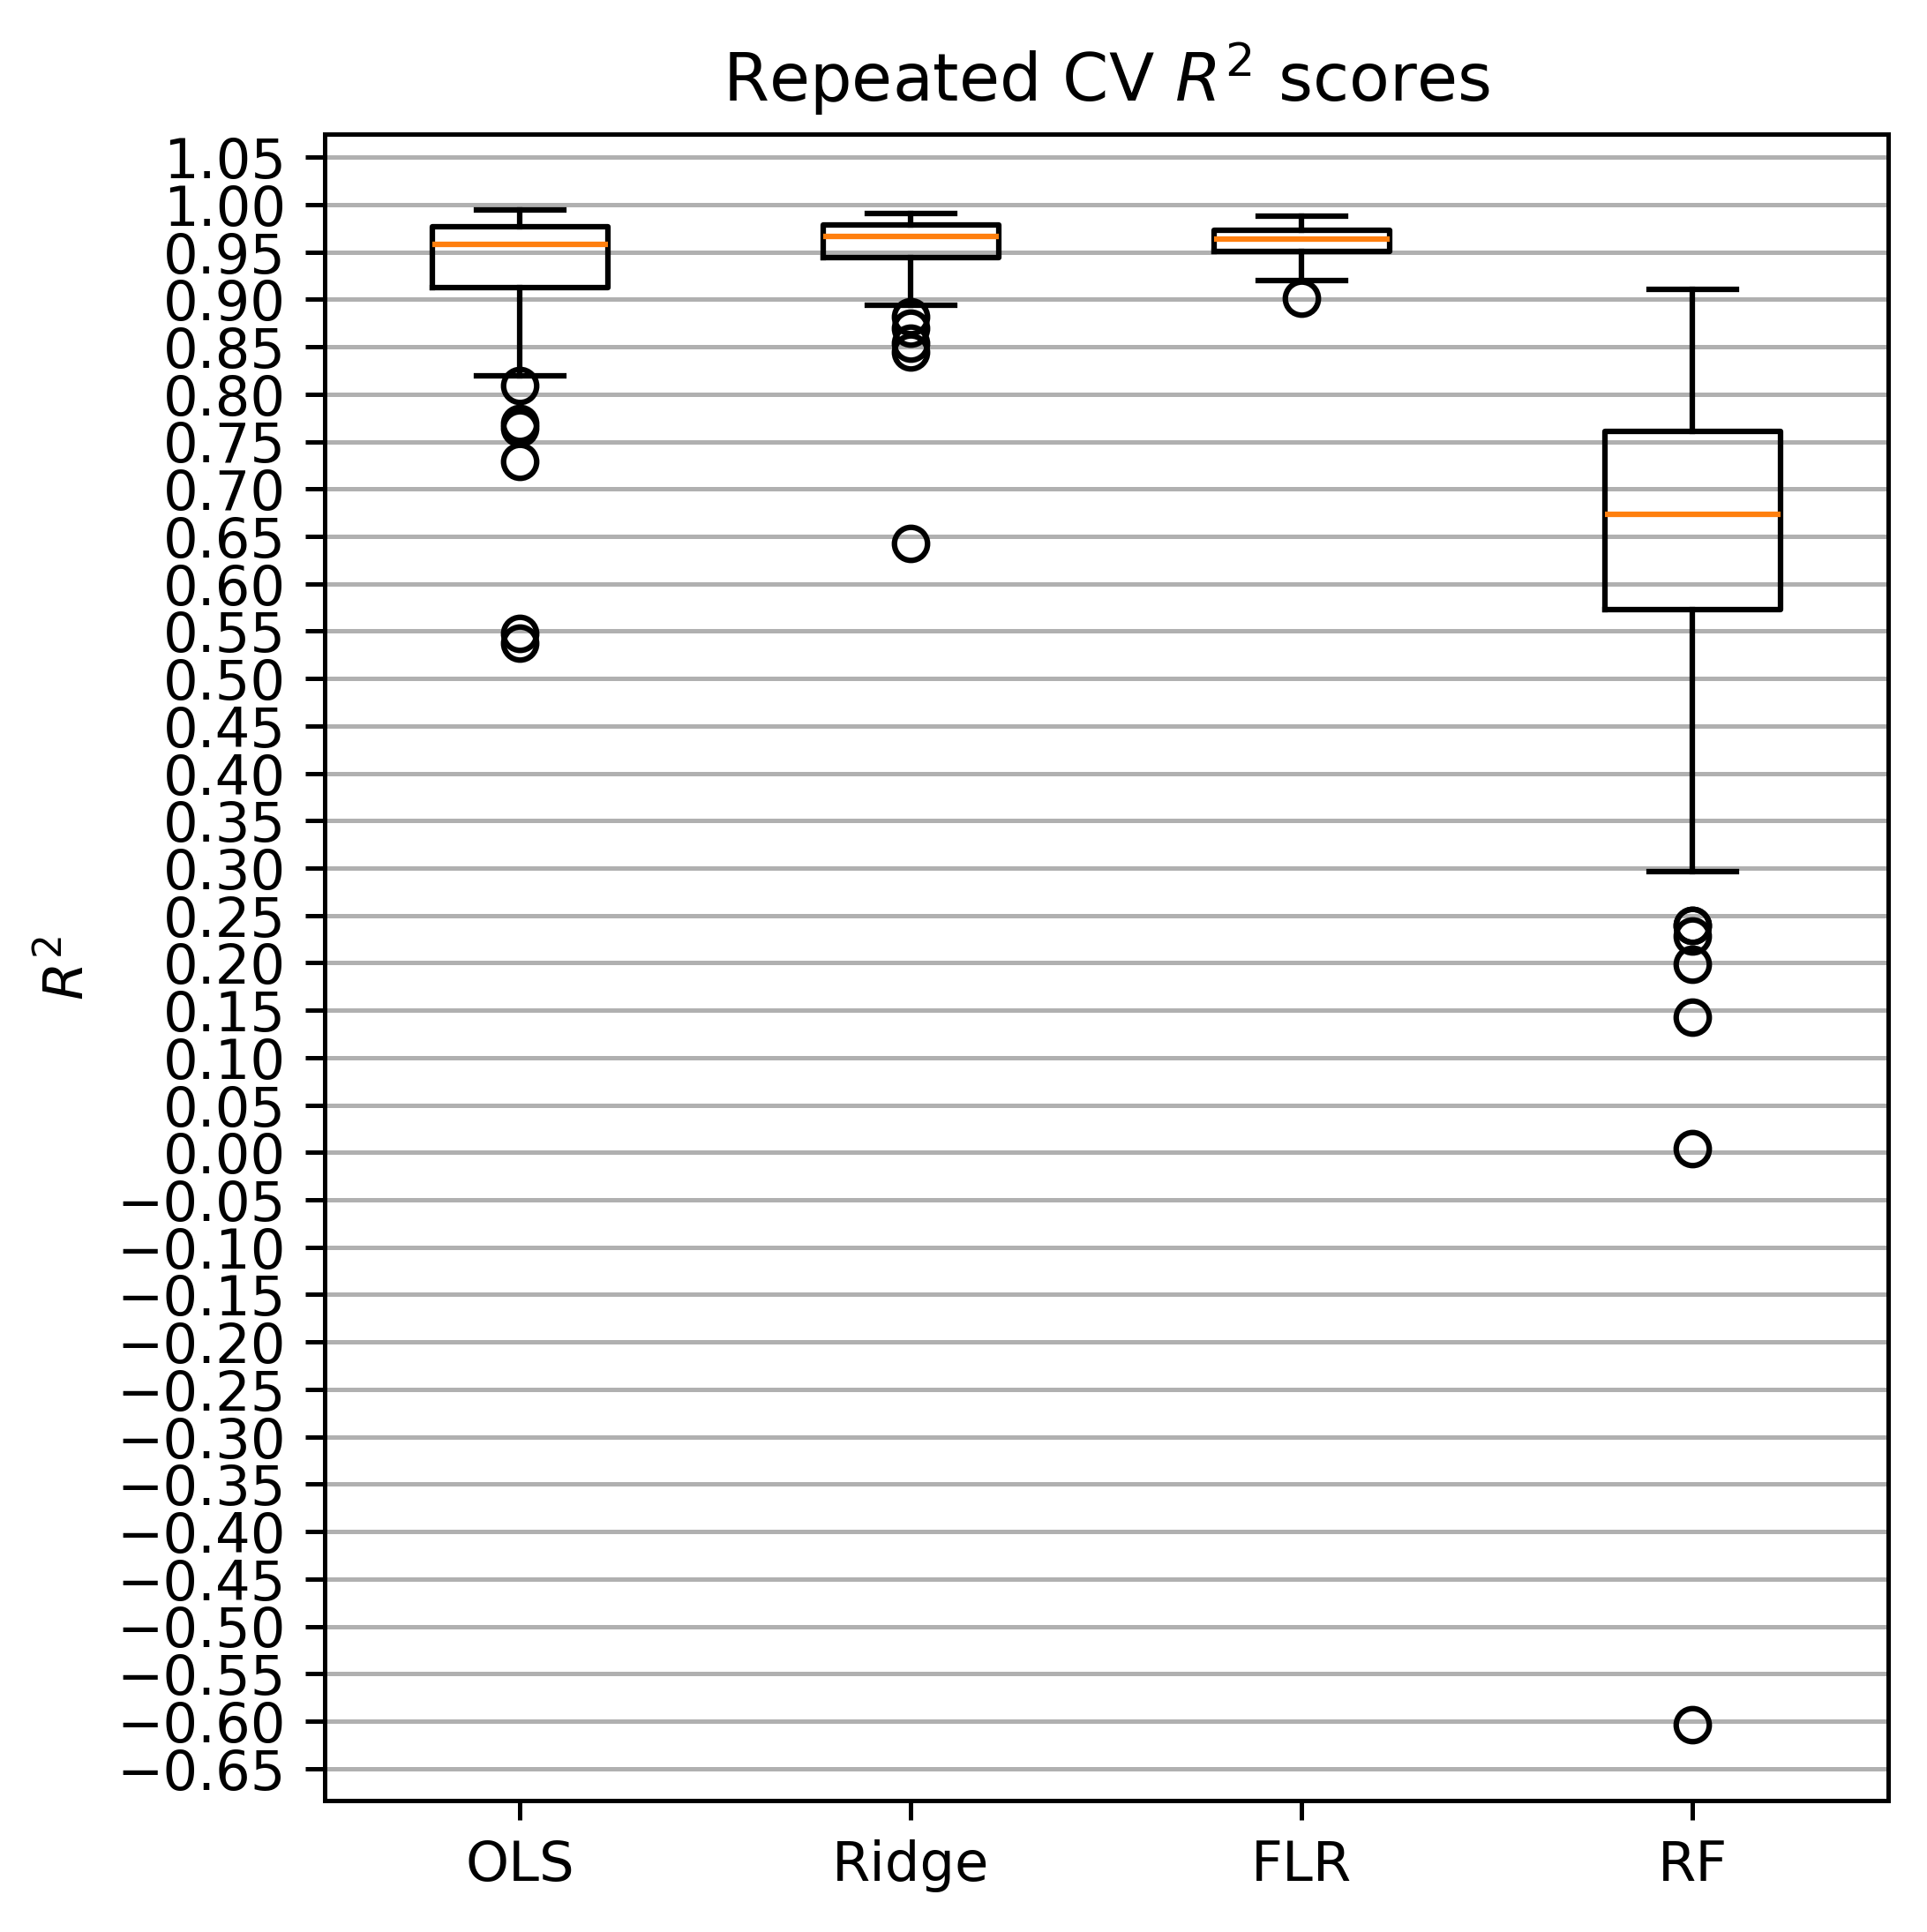

In [4]:
# Load the R^2 scores for both OLS, Ridge, FLR, and RF.
with open(str((artifacts_location_directory / "01_ols" / "results" / "ols_cv.pkl")), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/data/01_ols.
    ols_cv_scores = pickle.load(f).r2_scores

with open(str((artifacts_location_directory / "02_ridge" / "repeated_cv_results" / "results.pkl")), "rb") as f:
    ridge_cv_scores = pickle.load(f)

with open(str((artifacts_location_directory / "03_flr" / "repeated_cv_results" / "results.pkl")), "rb") as f:
    flr_cv_scores = pickle.load(f)["r2_scores"]

with open(str((artifacts_location_directory / "06_rf" / "repeated_cv_results" / "results.pkl")), "rb") as f:
    rf_cv_scores = pickle.load(f)

print("OLS CV R^2 median:", round(statistics.median(ols_cv_scores), 4))
print("OLS CV R^2 mean:", round(ols_cv_scores.mean(), 4))
print("OLS CV R^2 standard deviation:", round(ols_cv_scores.std(), 4))
print()
print("Ridge CV R^2 median:", round(statistics.median(ridge_cv_scores), 4))
print("Ridge CV R^2 mean:", round(ridge_cv_scores.mean(), 4))
print("Ridge CV R^2 standard deviation:", round(ridge_cv_scores.std(), 4))
print()
print("FLR CV R^2 median:", round(statistics.median(flr_cv_scores), 4))
print("FLR CV R^2 mean:", round(flr_cv_scores.mean(), 4))
print("FLR CV R^2 standard deviation:", round(flr_cv_scores.std(), 4))
print()
print("RF CV R^2 median:", round(statistics.median(rf_cv_scores), 4))
print("RF CV R^2 mean:", round(rf_cv_scores.mean(), 4))
print("RF CV R^2 standard deviation:", round(rf_cv_scores.std(), 4))
print()

Image(filename=str(artifacts_location_directory / "06_rf" / "plots" / "comparison.png"), width=400)

## Permute the wavelengths independently for each functional input

### Generate the data

In [ ]:
project_root = Path.cwd().resolve().parent
original_data_directory = project_root / "data" / "original"

new_directory_string = "07_permuted_indep"

new_data_directory = project_root / "data" / new_directory_string

new_data = generate_and_load_tecator_data_iid_noise(
    original_data_location=original_data_directory,
    new_data_location=new_data_directory,
    random_seed=0,
    alpha=0.,
    row_idx=None,
    col_idx=None,
    perm_cols_per_sample=True,
)

### Run the scripts

In [3]:
# Define the data directory to save to.
artifacts_location_directory = project_root / "artifacts" / new_directory_string
output_directory_1 = artifacts_location_directory / "01_ols"
output_directory_2 = artifacts_location_directory / "02_ridge"
output_directory_3 = artifacts_location_directory / "03_flr"
output_directory_6 = artifacts_location_directory / "06_rf"

# Define the data directories to read from.
data_location_directory = new_data_directory

%run ../scripts/01_ols.py --out-dir "{output_directory_1}" --data-location-directory "{new_data_directory}"
%run ../scripts/02_ridge.py --out-dir "{output_directory_2}" --data-location-directory "{data_location_directory}" --artifacts-location-directory "{artifacts_location_directory}"
%run ../scripts/03_flr.py --out-dir "{output_directory_3}" --data-location-directory "{data_location_directory}" --artifacts-location-directory "{artifacts_location_directory}"
%run ../scripts/06_rf.py --out-dir "{output_directory_6}" --data-location-directory "{data_location_directory}" --artifacts-location-directory "{artifacts_location_directory}"

162/1620 runs (10%) | elapsed 5.9s
324/1620 runs (20%) | elapsed 10.8s
486/1620 runs (30%) | elapsed 16.2s
648/1620 runs (40%) | elapsed 23.4s
810/1620 runs (50%) | elapsed 30.6s
972/1620 runs (60%) | elapsed 39.9s
1134/1620 runs (70%) | elapsed 47.2s
1296/1620 runs (80%) | elapsed 55.5s
1458/1620 runs (90%) | elapsed 67.0s
1620/1620 runs (100%) | elapsed 79.2s
Done with analysis plot generation! Proceding to repeated CV.


### Evaluate repeated CV $R^{2}$

We now repeat a similar experiment as in the end of the notebook `01_ols.ipynb`. We run 10-fold CV ridge regression 10 times to get 100 different generalization $R^{2}$ estimates. This means for each of the 100 estimates, we have CV train and test sets. We take each train set and perform another 10-fold CV to choose the best random forest hyperparameters, then evaluate the resulting random forest on the test set. We report the median, mean, standard deviation, and boxplot of the 100 resulting $R^{2}$ values.

OLS CV R^2 median: -0.9007
OLS CV R^2 mean: -1.0593
OLS CV R^2 standard deviation: 0.8513

Ridge CV R^2 median: 0.1201
Ridge CV R^2 mean: 0.1
Ridge CV R^2 standard deviation: 0.1726

FLR CV R^2 median: 0.0567
FLR CV R^2 mean: 0.0376
FLR CV R^2 standard deviation: 0.226

RF CV R^2 median: 0.2181
RF CV R^2 mean: 0.1613
RF CV R^2 standard deviation: 0.2163



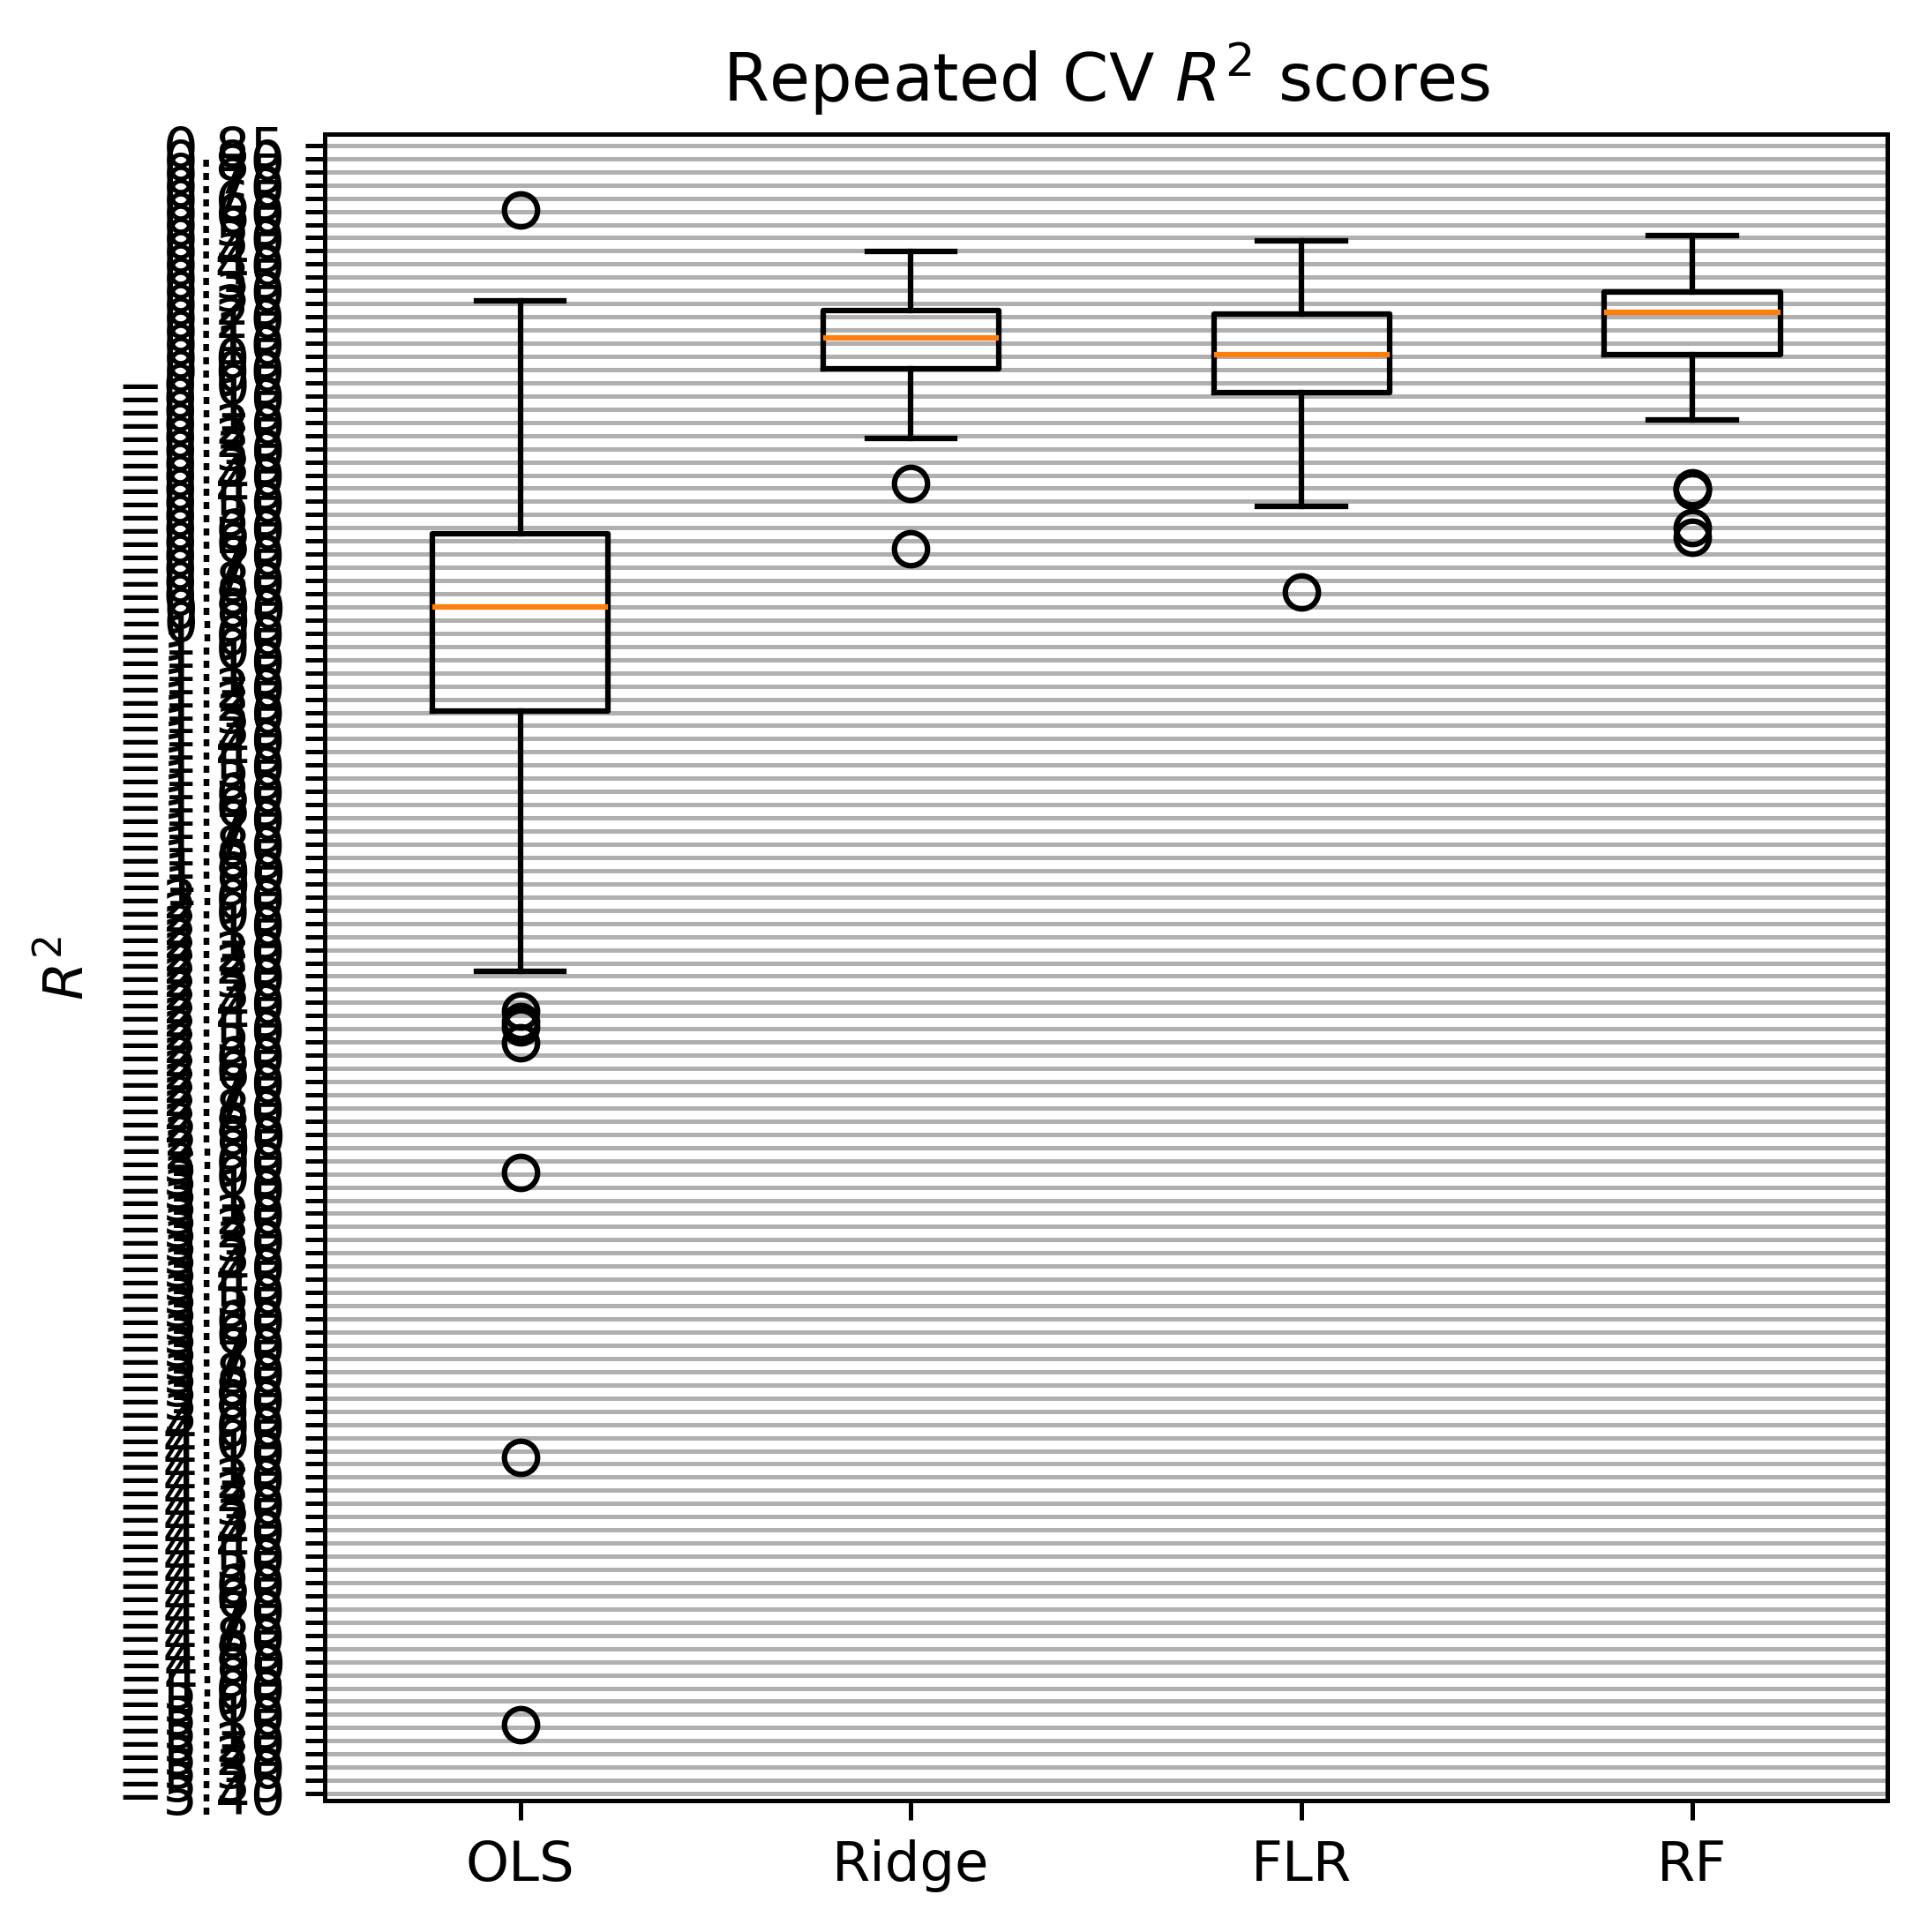

In [4]:
# Load the R^2 scores for both OLS, Ridge, FLR, and RF.
with open(str((artifacts_location_directory / "01_ols" / "results" / "ols_cv.pkl")), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/data/01_ols.
    ols_cv_scores = pickle.load(f).r2_scores

with open(str((artifacts_location_directory / "02_ridge" / "repeated_cv_results" / "results.pkl")), "rb") as f:
    ridge_cv_scores = pickle.load(f)

with open(str((artifacts_location_directory / "03_flr" / "repeated_cv_results" / "results.pkl")), "rb") as f:
    flr_cv_scores = pickle.load(f)["r2_scores"]

with open(str((artifacts_location_directory / "06_rf" / "repeated_cv_results" / "results.pkl")), "rb") as f:
    rf_cv_scores = pickle.load(f)

print("OLS CV R^2 median:", round(statistics.median(ols_cv_scores), 4))
print("OLS CV R^2 mean:", round(ols_cv_scores.mean(), 4))
print("OLS CV R^2 standard deviation:", round(ols_cv_scores.std(), 4))
print()
print("Ridge CV R^2 median:", round(statistics.median(ridge_cv_scores), 4))
print("Ridge CV R^2 mean:", round(ridge_cv_scores.mean(), 4))
print("Ridge CV R^2 standard deviation:", round(ridge_cv_scores.std(), 4))
print()
print("FLR CV R^2 median:", round(statistics.median(flr_cv_scores), 4))
print("FLR CV R^2 mean:", round(flr_cv_scores.mean(), 4))
print("FLR CV R^2 standard deviation:", round(flr_cv_scores.std(), 4))
print()
print("RF CV R^2 median:", round(statistics.median(rf_cv_scores), 4))
print("RF CV R^2 mean:", round(rf_cv_scores.mean(), 4))
print("RF CV R^2 standard deviation:", round(rf_cv_scores.std(), 4))
print()

Image(filename=str(artifacts_location_directory / "06_rf" / "plots" / "comparison.png"), width=400)